### **Galaxy Classifier**

In [1]:
# Install necessary libraries

!pip install -Uqq fastai gradio bing-image-downloader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127

In [2]:
#Import required libraries
import fastai
from fastai.vision.all import *
import gradio as gr
from bing_image_downloader import downloader
from pathlib import Path
import shutil


**Image Downloading**

In [3]:
def download_images_bing(search_term, dest_dir, max_images = 150):
  """
  Downloads images from Bing Image Search and saves them to the specified directory.
  """
  downloader.download(search_term,
                      limit = max_images,
                      output_dir = dest_dir,
                      adult_filter_off= False,
                      force_replace = False)

**Galaxy Categories**

In [4]:
galaxy_types = ['spiral galaxy', 'elliptical galaxy', 'irregular galaxy']
path = Path('galaxies')
path.mkdir(exist_ok=True) #Create main directory if it does not exist

**Download images for each galaxy type**

In [5]:
for galaxy_type in galaxy_types:
  dest = path/galaxy_type.replace(" ","_") # Replace spaces for better path handling
  dest.mkdir(exist_ok=True)
  download_images_bing(galaxy_type, dest.as_posix(), max_images = 200)

[%] Downloading Images to /content/galaxies/spiral_galaxy/spiral galaxy


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://scitechdaily.com/images/Spiral-Galaxy-NGC-5643.jpg
[Error]Invalid image, not saving https://scitechdaily.com/images/Spiral-Galaxy-NGC-5643.jpg

[!] Issue getting: https://scitechdaily.com/images/Spiral-Galaxy-NGC-5643.jpg
[!] Error:: Invalid image, not saving https://scitechdaily.com/images/Spiral-Galaxy-NGC-5643.jpg

[%] Downloading Image #1 from https://scitechdaily.com/images/Amazing-Hubble-Image-of-Spiral-Galaxy-NGC-7331.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://scitechdaily.com/images/Hubble-Views-Intermediate-Spiral-Galaxy-NGC-1566.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://apod.nasa.gov/apod/image/1411/m81_colombari_3200c.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://scitechdaily.com/images/Hubble-Views-Spiral-Galaxy-NGC-3455.jpg
[%] File Downloaded 

**Data Preparation**

In [6]:
# Get all downloaded image file paths
fns = get_image_files(path)
print(f"Total images found: {len(fns)}")


Total images found: 595


In [7]:
#Verify Image integrity
failed = verify_images(fns)
if len(failed) > 0:
  print(f"Removing {len(failed)} corrupted images.")
  for img in failed:
    img.unlink()
else:
  print("All images are valid.")


All images are valid.


**Data Loaders for Model Training**

In [8]:
def get_data_loaders(path, batch_size=64, img_size=128):
  """
    Creates a DataBlock pipeline with image transformations and loads data.
  """
  galaxies = DataBlock(
      blocks = (ImageBlock, CategoryBlock),
      get_items = get_image_files,
      splitter = RandomSplitter(valid_pct=0.2, seed=42),
      get_y = parent_label,
      item_tfms = Resize(img_size),
      batch_tfms=aug_transforms(size=img_size,
                                min_scale=0.5,
                                flip_vert=True,
                                max_rotate=30.0,
                                max_zoom=1.1,
                                max_lighting=0.2,
                                max_warp=0.2)
  )
  return galaxies.dataloaders(path, bs=batch_size)

dls = get_data_loaders(path)

**Show sample batch**

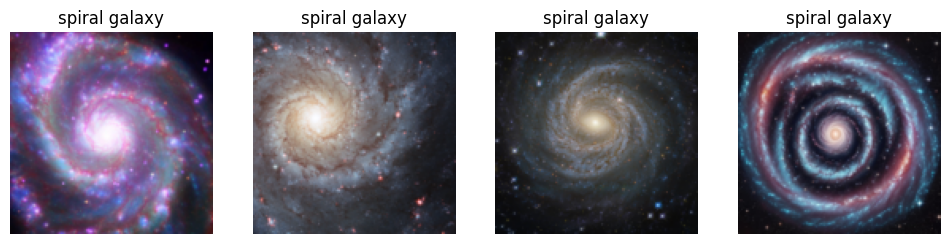

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

**Model Training**

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.704931,1.575493,0.588235,01:00


epoch,train_loss,valid_loss,accuracy,time
0,1.404471,1.021714,0.621849,01:13
1,1.273312,0.758092,0.722689,01:16
2,1.228914,0.575777,0.789916,01:13
3,1.142259,0.533123,0.806723,01:15
4,1.132436,0.535144,0.806723,01:15


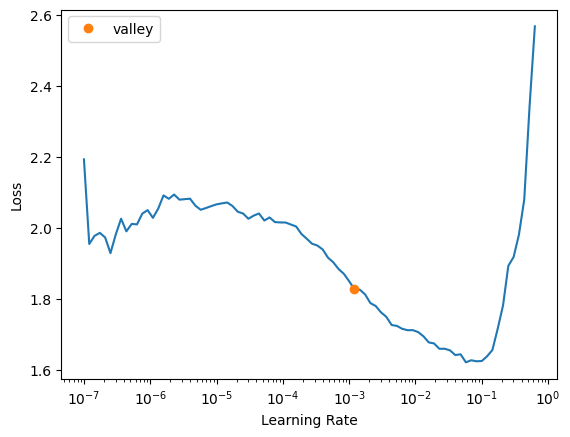

In [10]:
learn = vision_learner(dls, resnet18, metrics=accuracy, cbs=MixUp())

# Find the optimal learning rate
lr_min = learn.lr_find().valley  # Extract the best LR

# Fine-tune using the suggested learning rate
learn.fine_tune(5, base_lr=lr_min)

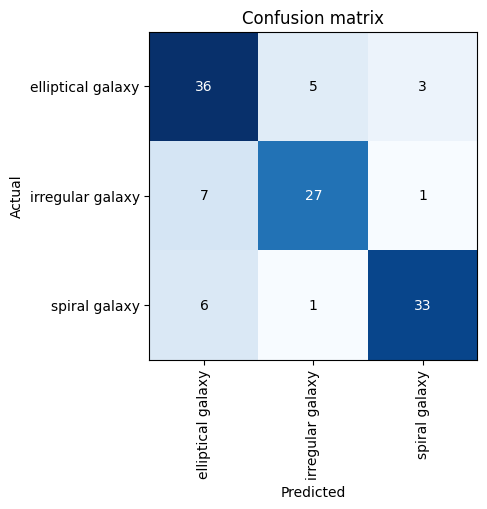

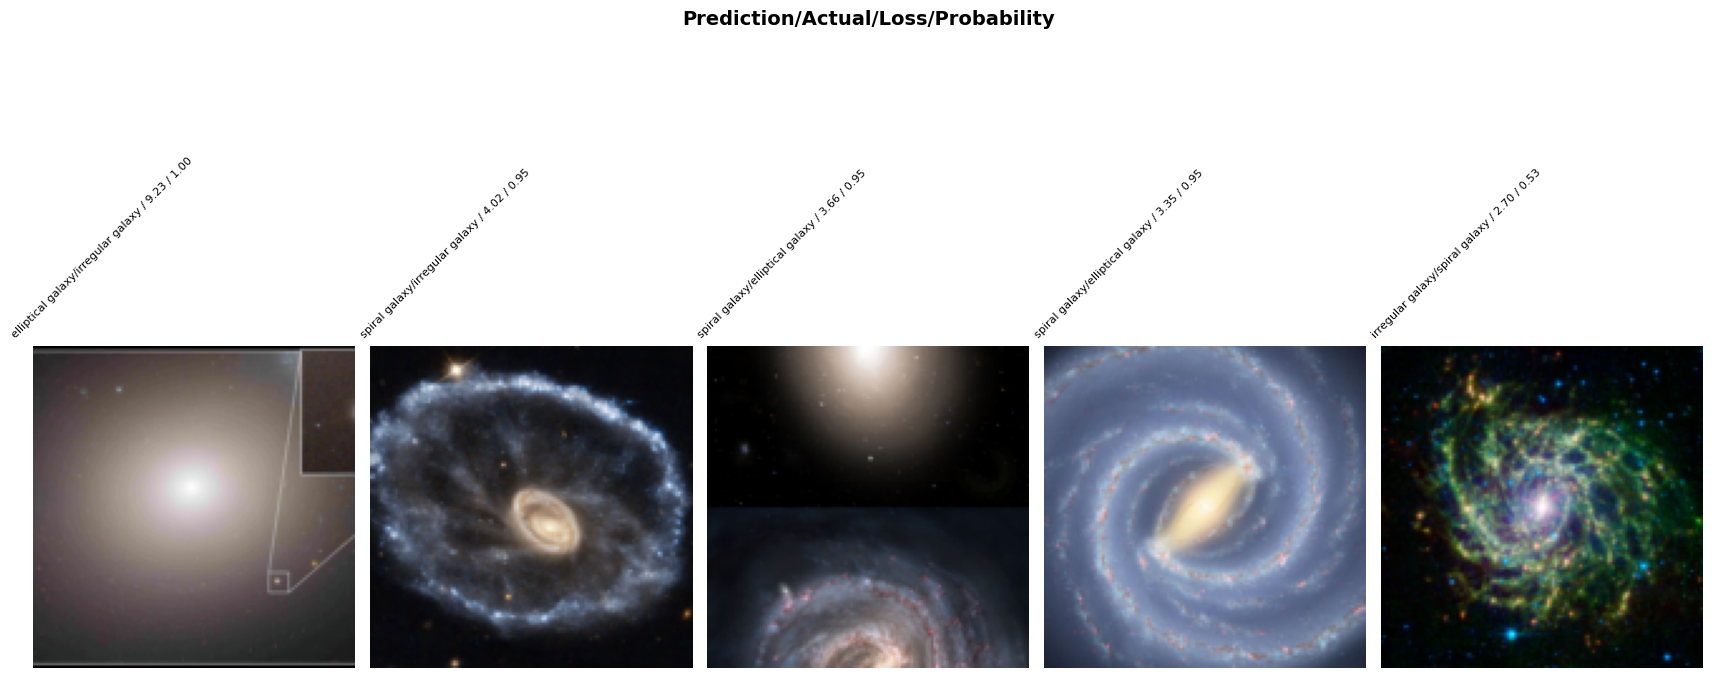

In [22]:
# Analyze model performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)  # Display confusion matrix
interp.plot_top_losses(5, nrows=1, figsize=(17,10))
for ax in plt.gcf().axes:
    ax.set_title(ax.get_title(), fontsize=8, rotation=45, ha='right')
    plt.tight_layout()

In [16]:
# --- Image Cleaning ---
from fastai.vision.widgets import ImageClassifierCleaner # Import ImageClassifierCleaner

# Provide a tool to clean misclassified images
cleaner = ImageClassifierCleaner(learn)
cleaner

In [19]:

for idx, action in cleaner.change():
    if action == 'keep':
        # Do nothing, image is already in the correct place
        pass
    elif action == 'delete':
        # Remove the image from the dataset
        fns[idx].unlink()
    elif isinstance(action, str):
        # Move the image to the new category folder
        new_category = Path(path/action)
        new_category.mkdir(exist_ok=True)
        shutil.move(fns[idx], new_category/fns[idx].name)
    else:
        print(f"Unknown action: {action} for index {idx}")

**Gradio Integration**

In [11]:
def predict_galaxy(img):
    """
    Predicts the galaxy type given an input image.
    """
    img = PILImage.create(img)
    prediction, _, probs = learn.predict(img)
    return {label: float(prob) for label, prob in zip(learn.dls.vocab, probs)}

In [12]:
# Create a Gradio interface
iface = gr.Interface(
    fn=predict_galaxy,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Galaxy Classifier",
    description="Upload an image of a galaxy to classify it as spiral, elliptical, or irregular."
)

In [13]:
# Launch the interface with a shareable link
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://192496b5b0b4d387ac.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [23]:
# To convert notebook to script to export as app.ipybn to huggingface
#from nbdev.export import notebook2script
#notebook2script('app.ipybn')